# DiploDatos Kaggle Competition

In [4]:
!uv pip install missingno scikit-learn pandas numpy matplotlib summarytools

Using Python 3.13.3 environment at: /home/matuu/diplodatos/.venv
Resolved 37 packages in 626ms                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)--------------     0 B/12.48 KiB           
Prepared 1 package in 174ms                                                  
Installed 1 package in 3ms                                  
 + summarytools==0.3.0


Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- Para esta competencia se elige como métrica el **recall_score**. Discutir, analizar y justificar porque es necesaria está métrica para este problema. 
- **Obtener una recall mejor que la que se presenta en este ejemplo.**
- Tratar de obtener un score lo más alto posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, ConfusionMatrixDisplay, classification_report, roc_auc_score, average_precision_score


from sklearn.tree import DecisionTreeClassifier

## Leer el dataset

### Train

Cargamos los datos de entrenamiento que vamos a utilizar para generar nuestro modelo. 

In [3]:
train_df = pd.read_csv('diabetes_prediction_dataset_train-labeled.csv')
print(train_df.shape)
print(train_df.describe())

(95000, 10)
             patient           age  hypertension  heart_disease           bmi  \
count   95000.000000  95000.000000  95000.000000   95000.000000  95000.000000   
mean    50016.501389     41.935269      0.075074       0.039463     27.320879   
std     28868.357071     22.514788      0.263512       0.194695      6.626335   
min         1.000000      0.080000      0.000000       0.000000     10.010000   
25%     25021.750000     24.000000      0.000000       0.000000     23.650000   
50%     50024.000000     43.000000      0.000000       0.000000     27.320000   
75%     75024.250000     60.000000      0.000000       0.000000     29.580000   
max    100000.000000     80.000000      1.000000       1.000000     95.690000   

        HbA1c_level  blood_glucose_level      diabetes  
count  95000.000000         95000.000000  95000.000000  
mean       5.527659           138.070537      0.085074  
std        1.070261            40.739962      0.278993  
min        3.500000           

In [4]:
train_df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


La columna ***`diabetes`*** es la columna que debemos predecir. En el dataset de Test esta columna tiene valores nulos.

### Test

Cargamos los datos de test. Estos datos son los que van a utilizar para predecir si las personas tienen diabetes y generar alrchivo `submision.csv` para utilizar en la competencia de Kaggle.

In [6]:
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')
print(test_df.shape)
print(test_df.describe())

(5000, 10)
            patient          age  hypertension  heart_disease          bmi  \
count   5000.000000  5000.000000   5000.000000    5000.000000  5000.000000   
mean   49696.473600    40.947016      0.070600       0.038600    27.318644   
std    28855.568156    22.537466      0.256181       0.192659     6.832943   
min        7.000000     0.160000      0.000000       0.000000    10.620000   
25%    24720.750000    23.000000      0.000000       0.000000    23.410000   
50%    49522.500000    41.000000      0.000000       0.000000    27.320000   
75%    74686.000000    59.000000      0.000000       0.000000    29.632500   
max    99970.000000    80.000000      1.000000       1.000000    88.760000   

       HbA1c_level  blood_glucose_level  diabetes  
count  5000.000000          5000.000000       0.0  
mean      5.524620           137.821000       NaN  
std       1.078559            40.101933       NaN  
min       3.500000            80.000000       NaN  
25%       4.800000        

In [7]:
test_df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,49267,Male,53.0,0,0,never,31.99,4.5,126,NaN
1,82280,Female,22.0,0,0,never,25.96,6.6,130,NaN
2,33216,Female,37.0,0,0,never,22.24,6.2,126,NaN
3,94551,Female,29.0,0,0,not current,31.01,5.0,80,NaN
4,43760,Male,30.0,0,0,ever,28.66,6.6,100,NaN


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              5000 non-null   int64  
 1   gender               5000 non-null   object 
 2   age                  5000 non-null   float64
 3   hypertension         5000 non-null   int64  
 4   heart_disease        5000 non-null   int64  
 5   smoking_history      5000 non-null   object 
 6   bmi                  5000 non-null   float64
 7   HbA1c_level          5000 non-null   float64
 8   blood_glucose_level  5000 non-null   int64  
 9   diabetes             0 non-null      float64
dtypes: float64(4), int64(4), object(2)
memory usage: 390.8+ KB


## Analisis de los datos 


In [6]:
from summarytools import dfSummary

dfSummary(train_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,patient[int64],Mean (sd) : 50016.5 (28868.4)min < med < max:1.0 < 50024.0 < 100000.0IQR (CV) : 50002.5 (1.7),"95,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAkZJREFUeJzt172PElEUhvFzYd1cPmTCh9DRWNpNQkNjZ+kfu609JNYUNlY0hITAEMYlEhwrExuRmYOLb/L82uXsOTd5CghFURjwv6vd+wDgGg/3PuCSEELDzB4rjn8viuL5lve8BOebzRzvvsHumpn9qDh78e6/huo83nN47PV6H5IkaVUZ3u12hxDCJzM7Vtzvub3qrOvNZq53u3afz+dXeZ6/bbfbX2u12qns/H6/34YQnv4U68VQQwiNfr//sdPpdMsu9h5+Op2imb2bTCafB4PBvszsarV6PZ/P34/H40G9Xi8dqud2z6znzWa+d3t3L5fL7mKxeJOm6ZfRaLQtM5tlWZzNZt3NZvNoZuVDNbPHTqfTnU6nz0mSlHq45/Df5psxxtNwOPxWZna73TZijM00TY+O3ZVuv8FspTeb+d59i91mZq1W61hl3swal/541XfUJElKL/ce/mvew7u7yvwtZr3uuftf4Vc/JBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJDxc86Esy2LZf3w4HKKZWZ7ncb1eN19yXnW36t3e+Wv6+glzeDC4AjEJlQAAAABJRU5ErkJggg=="">",0(0.0%)
2,gender[object],1. Female2. Male3. Other,"55,563 (58.5%)39,421 (41.5%)16 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAY9JREFUeJzt28FtwkAYBeG3yCLhYstCooSkB4pIsSnCRaQHhNhDIFycQ2rIrOSdr4IfNAIZ8cq6rpEIu9YHqB8lySHJvvUhnXiu63pvfUQrw/F4/BjHcW59SA9qrddSymevwQ3jOM7n8/k+TdOj9TFbdrvdXpdlmS+Xyz5Jn7ElyTRNj9Pp9N36mA4cWh/Qkg8IwhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMEPy91+r1odsne9xMtRar8uyzOn8v1aEWus1ybP1Ha24QWB1vUEoTvlE8ZOt808bUvfrqt4XT6Su11Uunliuq3wKx/ijrjDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJkzX66peX3cr3a+rel88kdwguEHAuK4SxgcEYYxNmF0p5b2U4lOZ/t0uyVuSl9aHaPv8GhXG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTZhdkq8kP60P0fa5rhLGr1FhfgHnRXM6cwavOAAAAABJRU5ErkJggg=="">",0(0.0%)
3,age[float64],Mean (sd) : 41.9 (22.5)min < med < max:0.1 < 43.0 < 80.0IQR (CV) : 36.0 (1.9),102 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAq1JREFUeJzt3U2O2jAYgOHPZRgZkGLxI9hxgZG6QGLDAbrsYXuELlh0zQ3YIaEoCGYQ4aeLttJUaiGJ8eAvep+9SRZvMLYjYS6XiwCx+/ToGwCKeHr0DeBvxpiWiDx7fMThcrm83et+YkGoETHGtPr9/tckSbpVP2Oz2aTGmG91i5VQ4/KcJEl3Npu9Oef2ZQdnWWbn83l3vV4/iwih4jqP6Ts5n89N51w6HA5fK16+VXFc1Aj1znym7zzP7el0etnv999FpGqotUSo91d5+l4ul93FYtE+Ho+NUDenFaEG4pzbl52+0zSt5bR9D+yjQgW+UWvmdDo1RSQxxlQZ7rUH67kHfPXahPofviv3e99PEbvdrpnn+efxeNxoNBqlt7d89mB994BvXbu2oXo+3bbX631xznXKDnzkyv1wODxZa9uTyWQ/Go3SMmPvsAdbeRFZ5Nq1DNX36c7z3IrIy3Q6/TEYDDZlxsawcu90OqUXcr95L+aqLCKLXLuWoYrnCc+f2Ky1OSv3ONQ1VBGp/nQTW3yiDlXjggZhRBsqR5F4L9pQhaNIvBNzqCLCUSR+uRlqyNMGoKiroYY+bQCKuvWNGvS0ASiq0G/UUKcNQFG85gcVCBUqRL89hY/j+S5r0NNAQoWI+L/LGvo0kFAhIn7vsoqEPw0MGmrMUwn+req7rKFPA4OFGvtUAl2ChRr7VAJdgv9GjXUqgS7so0IFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhT6s4ksy2zZD95ut1ZEZLfb2dVq1f7I8VqvrfW+fccX6esn/VOayDC7+WwAAAAASUVORK5CYII="">",0(0.0%)
4,hypertension[int64],1. 02. 1,"87,868 (92.5%)7,132 (7.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAThJREFUeJzt2zFqw0AURdE/QZi4mUEItBgtIovNImY3QmiK2LiZFEFNKv0xesbinlrFLy4CG71QazVAIZjZ1cwurz4Eb+lRa73tfbgbhuErxtgfeRHOqZSyhBC+9wbXxRj7aZpuKaX70cfhPNZ1/cw59/M8X8xsX2xmZiml+ziOP4dehzO6eh7+OOoK4D9igwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkOrO/D+FefQjeS0szXSllyTn35vwQDiilLGb22Ps8gxc8wzV4CUz5oNLyZnPVDGzcUz7vfAvYuKZ8LfMtYNMy5eNXK5rwpy5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SI

Sin valores nulos en el dataset

<Axes: xlabel='diabetes'>

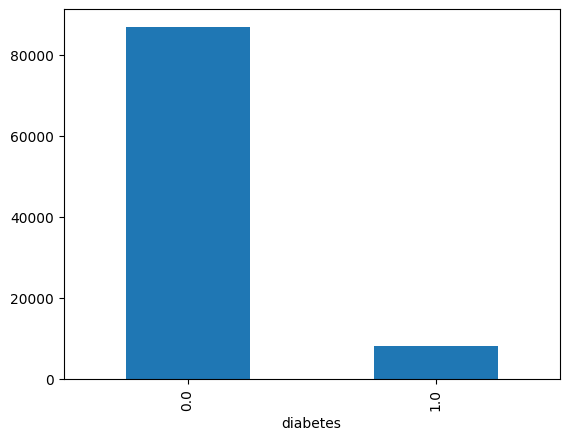

In [28]:
# Balanceo de clases
train_df.groupby("patient").diabetes.mean().value_counts().plot(kind='bar')

**¡Clases desbalanceadas!** Tiene sentido que haya más casos negativos que positivos, mas allá de que es una enfermedad frecuente, proporcionalmente, siendo una muestra representativa de la población, hay más gente sin diabetes que con ella.

¿Y que sucede si analizamos genero y edad?

<Axes: xlabel='gender'>

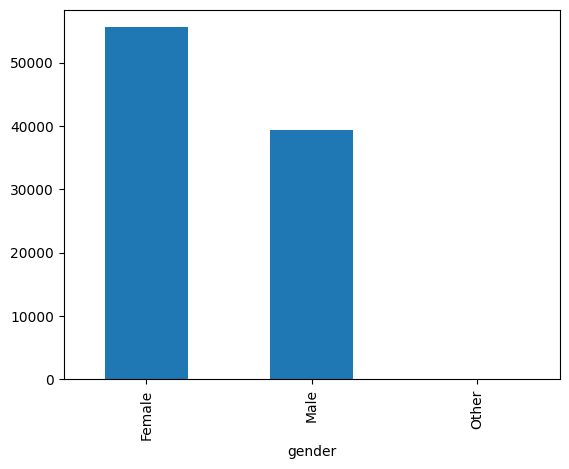

In [22]:
train_df.gender.value_counts().plot(kind='bar')

In [ ]:
train_df[train_df["gender"] == "Other"].shape

(16, 10)

<Axes: xlabel='gender'>

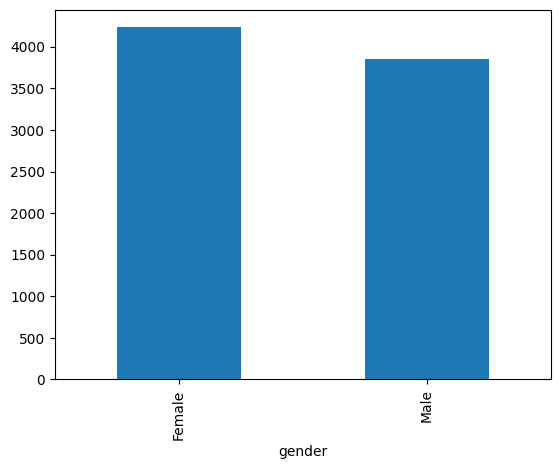

In [42]:
train_df[train_df["diabetes"] == 1].gender.value_counts().plot(kind='bar')

<Axes: xlabel='gender'>

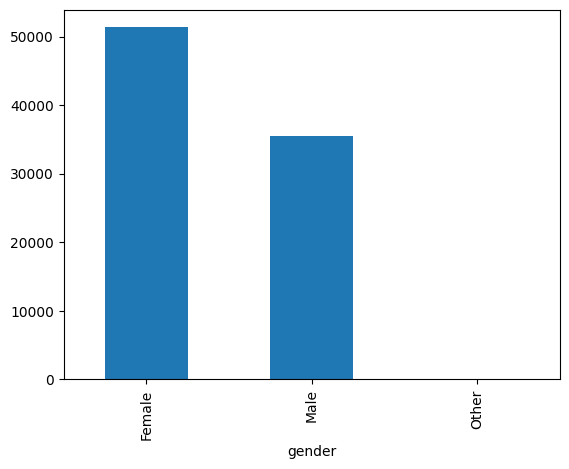

In [43]:
train_df[train_df["diabetes"] == 0].gender.value_counts().plot(kind='bar')

<Axes: >

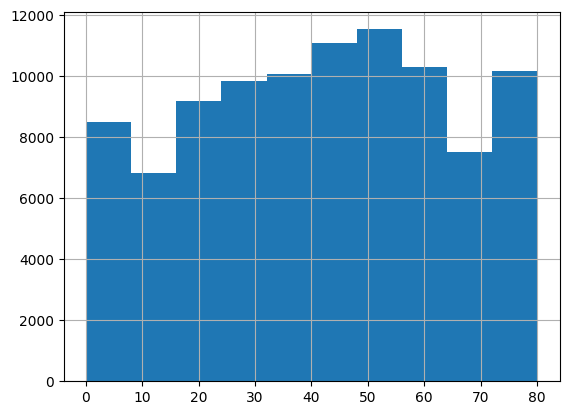

In [37]:
train_df.age.hist(bins=10)

In [39]:
print("Edad mínima %s y edad máxima %s" % (train_df.age.min(), train_df.age.max()))

Edad mínima 0.08 y edad máxima 80.0


In [8]:
train_df_c = train_df.copy()

Necesitamos contruir nuestros conjuntos de datos para realizar los entrenamientos:

In [9]:
imputer_cols = ["patient", "age", "hypertension", "heart_disease", "bmi" ,"HbA1c_level", "blood_glucose_level", "diabetes"]
imputer = SimpleImputer(strategy="median")
train_df_c[imputer_cols] = imputer.fit_transform(train_df[imputer_cols])
y = train_df_c.diabetes
X = train_df_c.drop('diabetes',axis=1)
X

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,20432.0,Male,4.0,0.0,0.0,never,19.28,3.5,155.0
1,49682.0,Female,50.0,0.0,0.0,former,27.32,5.7,159.0
2,73886.0,Female,43.0,0.0,0.0,never,21.54,4.5,145.0
3,53144.0,Male,64.0,0.0,0.0,current,28.22,6.0,130.0
4,98507.0,Male,10.0,0.0,0.0,No Info,15.46,6.1,140.0
...,...,...,...,...,...,...,...,...,...
94995,81090.0,Female,56.0,0.0,0.0,never,22.30,6.2,158.0
94996,90924.0,Female,24.0,0.0,0.0,never,22.50,6.1,126.0
94997,64600.0,Female,32.0,0.0,0.0,never,24.92,6.6,145.0
94998,96132.0,Female,21.0,0.0,0.0,current,20.59,4.5,155.0


In [10]:
train_df

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0
...,...,...,...,...,...,...,...,...,...,...
94995,81090,Female,56.0,0,0,never,22.30,6.2,158,0
94996,90924,Female,24.0,0,0,never,22.50,6.1,126,0
94997,64600,Female,32.0,0,0,never,24.92,6.6,145,0
94998,96132,Female,21.0,0,0,current,20.59,4.5,155,0


Vamos a separar la columna con los Id de los pacientes en una sola variable:

In [11]:
patientId = X.patient
X.drop('patient',axis=1,inplace=True)

Necesitamos transformar las variables que son categoricas a númericas, como por ejemplo **gender** y **smoking_history**

In [12]:
print(X.columns)
label_cols = ["gender", "smoking_history"]

for col in label_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])
X

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level'],
      dtype='object')


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1,4.0,0.0,0.0,4,19.28,3.5,155.0
1,0,50.0,0.0,0.0,3,27.32,5.7,159.0
2,0,43.0,0.0,0.0,4,21.54,4.5,145.0
3,1,64.0,0.0,0.0,1,28.22,6.0,130.0
4,1,10.0,0.0,0.0,0,15.46,6.1,140.0
...,...,...,...,...,...,...,...,...
94995,0,56.0,0.0,0.0,4,22.30,6.2,158.0
94996,0,24.0,0.0,0.0,4,22.50,6.1,126.0
94997,0,32.0,0.0,0.0,4,24.92,6.6,145.0
94998,0,21.0,0.0,0.0,1,20.59,4.5,155.0


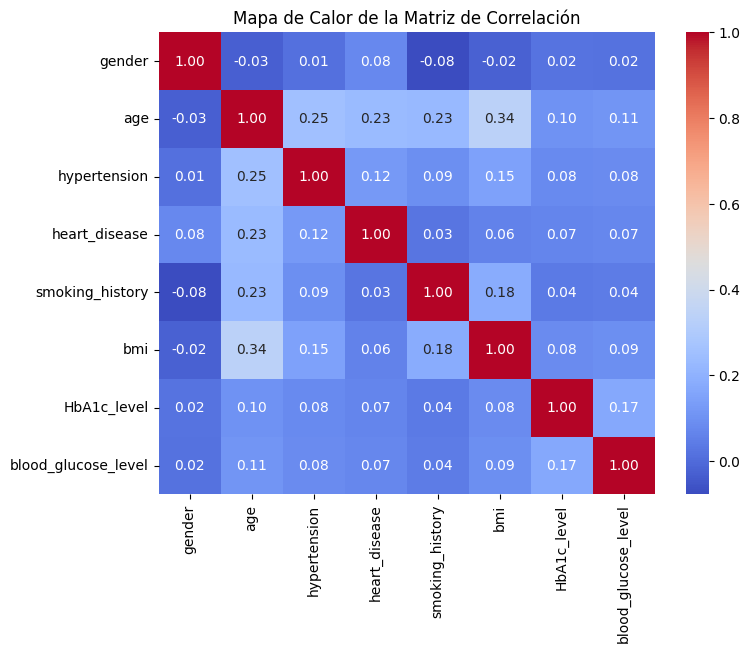

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Calor de la Matriz de Correlación")
plt.show()


Se observa cierta correlación entre la edad del paciente, y la hipertensión, enfermedades del corazón y el historial como fumador:
- La hipertensión en edades tempranas es muy poco común.
- Los problemas cardíacos en niños suelen ser congenitos.
- Las personas no fuman en edades tempranas, por lo que tiene sentido que se observen más casos en edades superiores.

Necesitamos también estandarizar las variables:

In [17]:
x_names = X.columns
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=x_names)
X

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1.185739,-1.684913,-0.284899,-0.202693,0.961962,-1.213479,-1.894556,0.415552
1,-0.842187,0.358199,-0.284899,-0.202693,0.432680,-0.000133,0.161028,0.513736
2,-0.842187,0.047291,-0.284899,-0.202693,0.961962,-0.872414,-0.960200,0.170091
3,1.185739,0.980016,-0.284899,-0.202693,-0.625885,0.135690,0.441335,-0.198100
4,1.185739,-1.418420,-0.284899,-0.202693,-1.155167,-1.789970,0.534771,0.047361
...,...,...,...,...,...,...,...,...
94995,-0.842187,0.624692,-0.284899,-0.202693,0.961962,-0.757720,0.628206,0.489190
94996,-0.842187,-0.796604,-0.284899,-0.202693,0.961962,-0.727537,0.534771,-0.296284
94997,-0.842187,-0.441280,-0.284899,-0.202693,0.961962,-0.362326,1.001949,0.170091
94998,-0.842187,-0.929850,-0.284899,-0.202693,-0.625885,-1.015782,-0.960200,0.415552


A partir de los datos en las variables `X` e `y` separamos en train y en test:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 42)

### Planteo de modelos

En primer caso, se plantea un modelo de regresión logística (RandomForestClassifier)

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Dado nuestro desbalance en las clases
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"AUC-PR: {average_precision_score(y_test, y_pred_proba):.3f}")
print(f"Recall test: %.2f%%" % (recall_score(y_test, y_pred) * 100.0))

y_pred_train = rf.predict(X_train)
recall_train = recall_score(y_train, y_pred_train)
print("Recall train: %.2f%%" % (recall_train * 100.0))



              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94     17401
         1.0       0.46      0.91      0.61      1599

    accuracy                           0.90     19000
   macro avg       0.73      0.90      0.78     19000
weighted avg       0.95      0.90      0.92     19000

AUC-ROC: 0.974
AUC-PR: 0.877
Recall test: 90.56%
Recall train: 92.78%


Estos resultados son muy bueno, encontramos 9 de cada 10 pacientes con diabetes. Aunque la precision es baja, casi 5 de cada 10 pacientes que detectamos con diabetes es incorrecto.


In [53]:
#calculamos el desbalance
negative, positive = train_df.diabetes.value_counts()
total = negative + positive
scale_pos_weight = (negative/total) / (positive/total)
print(scale_pos_weight)


10.754516208859194


In [38]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"AUC-PR: {average_precision_score(y_test, y_pred_proba):.3f}")
print(f"Recall test: %.2f%%" % (recall_score(y_test, y_pred) * 100.0))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95     17401
         1.0       0.47      0.91      0.62      1599

    accuracy                           0.90     19000
   macro avg       0.73      0.91      0.78     19000
weighted avg       0.95      0.90      0.92     19000

AUC-ROC: 0.978
AUC-PR: 0.884
Recall test: 90.93%


In [52]:
# El XGBoost no mejora sustencialmente, prosigamos con una optimización de hiperparámetros.
from sklearn.model_selection import GridSearchCV

param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight)
grid_search = GridSearchCV(estimator= xgb_clf, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor recall:", grid_search.best_score_)

best_xgb_clf = grid_search.best_estimator_
best_xgb_clf.fit(X_train, y_train)

y_pred = best_xgb_clf.predict(X_test)
y_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"AUC-PR: {average_precision_score(y_test, y_pred_proba):.3f}")
print(f"Recall test: %.2f%%" % (recall_score(y_test, y_pred) * 100.0))


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


Mejores hiperparámetros: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
Mejor recall: 0.9441592421257031
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92     17401
         1.0       0.37      0.93      0.53      1599

    accuracy                           0.86     19000
   macro avg       0.68      0.89      0.73     19000
weighted avg       0.94      0.86      0.89     19000

AUC-ROC: 0.974
AUC-PR: 0.868
Recall test: 93.25%


Seleccionando los mejores valores del grid, vamos a probar otros pesos para ver si mejora el recall

In [59]:
# Prueba diferentes pesos manteniendo los otros parámetros optimizados
best_params = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.01, 
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.9
}

# Probar pesos alrededor del actual
for weight in [8, 10.754, 15, 20]:
    xgb_test = xgb.XGBClassifier(scale_pos_weight=weight, **best_params)
    # Evaluar recall
    xgb_test.fit(X_train, y_train)
    y_pred = xgb_test.predict(X_test)
    print("#" * 50, weight, "#" * 50)
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"{classification_report(y_test, y_pred)}")
    

################################################## 8 ##################################################
Recall: 0.859
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     17401
         1.0       0.54      0.86      0.66      1599

    accuracy                           0.93     19000
   macro avg       0.76      0.90      0.81     19000
weighted avg       0.95      0.93      0.93     19000

################################################## 10.754 ##################################################
Recall: 0.932
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92     17401
         1.0       0.37      0.93      0.53      1599

    accuracy                           0.86     19000
   macro avg       0.68      0.89      0.73     19000
weighted avg       0.94      0.86      0.89     19000

################################################## 15 ##################################################


Con pesos más agresivos, el recall sube a 0.969. Toca comprobar con cross validation si no tenemos overfitting.

In [56]:
from sklearn.model_selection import cross_val_score

xgb_final = xgb.XGBClassifier(
    scale_pos_weight=20,
    colsample_bytree=0.9,
    learning_rate=0.01,
    max_depth=5,
    n_estimators=200,
    subsample=0.9,
    random_state=42
)

recall_cv = cross_val_score(xgb_final, X_train, y_train, cv=5, scoring='recall')
print(f"Recall CV: {recall_cv.mean():.3f} (+/- {recall_cv.std() * 2:.3f})")

Recall CV: 0.975 (+/- 0.010)


### Validación exitosa:

- Recall CV: 97.5% (±1.0%) - Muy estable entre folds
- Recall test: 96.9% - Consistente con CV, no hay overfitting
- Varianza mínima - El +/- 1.0% indica que el modelo es robusto

In [70]:
# Entrenar el modelo final. Pero esta vez con todo el dataset (dado que el verdadero conjunto de tests es el que está en kaggle)
xgb_final = xgb.XGBClassifier(
    scale_pos_weight=20,
    colsample_bytree=0.9,
    learning_rate=0.01,
    max_depth=5,
    n_estimators=200,
    subsample=0.9,
    random_state=42
)
xgb_final.fit(X, y)
y_pred = xgb_final.predict(X)
y_pred_proba = xgb_final.predict_proba(X)[:, 1]
print(classification_report(y, y_pred))
print(f"AUC-ROC: {roc_auc_score(y, y_pred_proba):.3f}")
print(f"AUC-PR: {average_precision_score(y, y_pred_proba):.3f}")
print(f"Recall test: %.2f%%" % (recall_score(y, y_pred) * 100.0))

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89     86918
         1.0       0.31      0.98      0.47      8082

    accuracy                           0.81     95000
   macro avg       0.65      0.89      0.68     95000
weighted avg       0.94      0.81      0.85     95000

AUC-ROC: 0.976
AUC-PR: 0.873
Recall test: 97.90%


## Generar la salida para entregar

In [61]:
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')


In [62]:
test_df

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,49267,Male,53.0,0,0,never,31.99,4.5,126,NaN
1,82280,Female,22.0,0,0,never,25.96,6.6,130,NaN
2,33216,Female,37.0,0,0,never,22.24,6.2,126,NaN
3,94551,Female,29.0,0,0,not current,31.01,5.0,80,NaN
4,43760,Male,30.0,0,0,ever,28.66,6.6,100,NaN
...,...,...,...,...,...,...,...,...,...,...
4995,88540,Female,23.0,0,0,never,22.77,6.6,200,NaN
4996,26701,Female,51.0,0,0,No Info,27.32,4.0,155,NaN
4997,47271,Male,79.0,0,0,No Info,23.80,6.0,126,NaN
4998,97941,Male,24.0,0,0,never,22.68,6.1,85,NaN


Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [63]:
Y_test = test_df.diabetes
PatientId_test = test_df['patient']
X_test = test_df.drop(['patient','diabetes'],axis=1,inplace=True)


In [64]:
X_test = test_df

In [65]:
imputer_cols = ["age", "hypertension", "heart_disease", "bmi" ,"HbA1c_level", "blood_glucose_level"]
imputer = SimpleImputer(strategy="median")
X_test[imputer_cols] = imputer.fit_transform(X_test[imputer_cols])

In [66]:
label_cols = ["gender", "smoking_history"]

for col in label_cols:
    X_test[col] = X_test[col].astype(str)
    X_test[col] = LabelEncoder().fit_transform(X_test[col])
X_test

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1,53.0,0.0,0.0,4,31.99,4.5,126.0
1,0,22.0,0.0,0.0,4,25.96,6.6,130.0
2,0,37.0,0.0,0.0,4,22.24,6.2,126.0
3,0,29.0,0.0,0.0,5,31.01,5.0,80.0
4,1,30.0,0.0,0.0,2,28.66,6.6,100.0
...,...,...,...,...,...,...,...,...
4995,0,23.0,0.0,0.0,4,22.77,6.6,200.0
4996,0,51.0,0.0,0.0,0,27.32,4.0,155.0
4997,1,79.0,0.0,0.0,0,23.80,6.0,126.0
4998,1,24.0,0.0,0.0,4,22.68,6.1,85.0


In [67]:
cols = X_test.columns
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [68]:
X_test

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1.216115,0.534851,-0.275614,-0.200374,0.989602,0.683720,-0.950085,-0.294803
1,-0.819565,-0.840774,-0.275614,-0.200374,0.989602,-0.198857,0.997153,-0.195048
2,-0.819565,-0.175149,-0.275614,-0.200374,0.989602,-0.743333,0.626250,-0.294803
3,-0.819565,-0.530149,-0.275614,-0.200374,1.517446,0.540283,-0.486457,-1.441995
4,1.216115,-0.485774,-0.275614,-0.200374,-0.066086,0.196327,0.997153,-0.943216
...,...,...,...,...,...,...,...,...
4995,-0.819565,-0.796399,-0.275614,-0.200374,0.989602,-0.665760,0.997153,1.550679
4996,-0.819565,0.446101,-0.275614,-0.200374,-1.121774,0.000198,-1.413713,0.428426
4997,1.216115,1.688601,-0.275614,-0.200374,-1.121774,-0.515004,0.440799,-0.294803
4998,1.216115,-0.752024,-0.275614,-0.200374,0.989602,-0.678933,0.533525,-1.317300


Generamos la salida

In [71]:
test_id = PatientId_test
test_pred = np.int64(xgb_final.predict(X_test))

Con el resultado predicho tenemos que generar el archivo `.csv` para subir a la competencia de kaggle:

In [72]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("xgboostsubmission.csv", header=True, index=False)

In [73]:
submission

,patient,diabetes
0,49267,0
1,82280,0
2,33216,0
3,94551,0
4,43760,0
...,...,...
4995,88540,0
4996,26701,0
4997,47271,1
4998,97941,0


Otras cosas a probar:
- No escalar, creo que xgboost no es necesario escalar.
- Probar con otro encoder (onehot encoder).
- Probar con otro modelo (random forest) con estos cambios.


**Suerte!! :D**